In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from core import DataLoader
from enums import PostType, VoteType

In [25]:
Ethereum = DataLoader('../data/ethereum')

In [2]:
Crypto = DataLoader('../data/crypto')

In [3]:
Christianity = DataLoader('../data/christianity')

In [23]:
Judaism = DataLoader('../data/judaism')

In [274]:
def get_per_year_counts_for_tags(posts, *tags):
    res = []
    
    for year in posts['Year'].unique():
        posts_by_year = posts[posts['Year'] == year]
        posts_ = posts_by_year
        
        for tag in tags:
            posts_ = posts_[posts_['Tags'].str.contains(f'<{tag}>', regex=False, na=False)]
        res.append(len(posts_))

    return res

In [275]:
x = list(posts['Year'].unique())
y1 = get_per_year_counts_for_tags('attack')
y2 = get_per_year_counts_for_tags('encryption')
y3 = get_per_year_counts_for_tags('public-key')
y4 = get_per_year_counts_for_tags('elliptic-curves')
y5 = get_per_year_counts_for_tags('block-cipher')

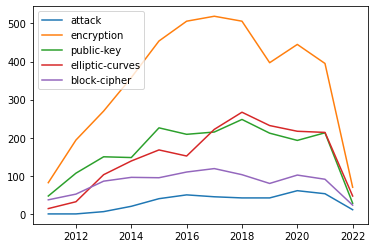

In [276]:
plt.plot(x, y1, label='attack')
plt.plot(x, y2, label='encryption')
plt.plot(x, y3, label='public-key')
plt.plot(x, y4, label='elliptic-curves')
plt.plot(x, y5, label='block-cipher')
plt.legend()
plt.show()

In [277]:
x = list(posts['Year'].unique())
y1 = get_per_year_counts_for_tags('attack')
y2 = get_per_year_counts_for_tags('block-cipher')
y3 = get_per_year_counts_for_tags('attack', 'block-cipher')

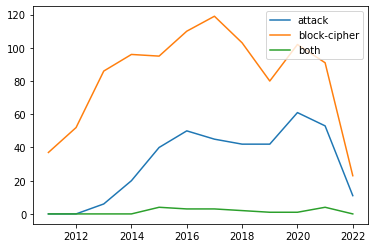

In [278]:
plt.plot(x, y1, label='attack')
plt.plot(x, y2, label='block-cipher')
plt.plot(x, y3, label='both')
plt.legend()
plt.show()

In [279]:
x = list(posts['Year'].unique())
y1 = get_per_year_counts_for_tags('public-key')
y2 = get_per_year_counts_for_tags('elliptic-curves')
y3 = get_per_year_counts_for_tags('public-key', 'elliptic-curves')

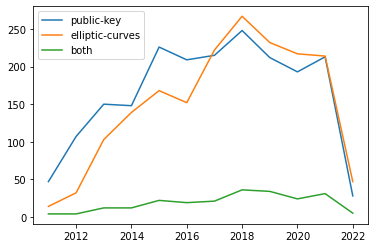

In [280]:
plt.plot(x, y1, label='public-key')
plt.plot(x, y2, label='elliptic-curves')
plt.plot(x, y3, label='both')
plt.legend()
plt.show()

In [3]:
def get_tags(posts):
    tags = set()
    for tags_string in posts['Tags'].unique():
        if not tags_string:
            continue

        tags_ = tags_string.split('><')
        tags_ = [x.strip('<').strip('>') for x in tags_]

        tags.update(tags_)
    
    return tags

In [54]:
def find_sub_tags(posts_df, precision=.5):
    posts = posts_df
    
    tags = get_tags(posts)
    
    tag_n = {}
    for tag in tags:
        tag_n[tag] = len(posts[posts['Tags'].str.contains(f'<{tag}>', regex=False, na=False)])
    
    co_tags = {}
    for index, row in posts.iterrows():
        if not row['Tags']:
            continue

        tags_ = row['Tags'].split('><')
        tags_ = [x.strip('<').strip('>') for x in tags_]

        for tag1 in tags_:
            for tag2 in tags_:
                if tag1 >= tag2:
                    continue
                co_tags[(tag1, tag2)] = co_tags.get((tag1, tag2), 0) + 1
    
    likely_parent = {}
    for tag in tags:
        parent = None
        union_percent = 0

        for p in tags:
            if (nu := co_tags.get((min(tag, p), max(tag, p)))):
                if precision * 100 < (u_percent := nu / tag_n[tag] * 100) and u_percent > union_percent:
                    union_percent = u_percent
                    parent = p

        if parent:
            likely_parent[tag] = parent

    likely_children = {}
    for tag in likely_parent.values():
        likely_children[tag] = []
        for child, p in likely_parent.items():
            if tag == p:
                likely_children[tag].append(child)
    
    class Node:
        def __init__(self, name):
            self.name = name
            self.children = []
            self.parent = None

        def show(self, offset=0):
            print(self.name, end='')

            if self.children:
                print()
                for child in self.children:
                    print(' ' * (offset + len(self.name) - 1) + '|- ', end='')
                    child.show(offset + len(self.name) + 2)

            print()
    
    nodes = [Node(t) for t in tags]
    
    for parent, children in likely_children.items():
        parent = [node for node in nodes if node.name == parent][0]
        for child in children:
            child = [node for node in nodes if node.name == child][0]
            child.parent = parent
            parent.children.append(child)
        parent.children.sort(key=lambda x: x.name)
    
    nodes.sort(key=lambda x: x.name)
    for parent in nodes:
        if parent.parent is None and parent.children:
            parent.show()

In [55]:
find_sub_tags(Crypto.posts_df.copy())

aes
  |- biclique-attack
  |- camellia
  |- ctr
  |- gcm
       |- ghash
       |- sgcm

  |- kalyna
  |- mds
  |- rijndael
  |- serpent
  |- twofish

attack
     |- sec

authenticated-encryption
                       |- eax

block-cipher
           |- blocksize
           |- tweakable-cipher

certificates
           |- crl

coding-theory
            |- hermitian-curves

cryptanalysis
            |- lucas

des
  |- desx

diffie-hellman
             |- logjam

discrete-logarithm
                 |- ggm
                 |- pohlig-hellman
                 |- pollard-rho

dsa
  |- rfc6979

elgamal-encryption
                 |- hashed-elgamal

elliptic-curves
              |- eddsa
              |- elliptic-curve-generation
              |- isogeny
              |- rfc7748
              |- secp256k1
              |- x25519

encryption
         |- cryptdb
         |- decryption
         |- fips
         |- host-proof
         |- military-encryption
         |- ransomware
         |- traffi

In [7]:
def difficulty_getting_badge(db):
    badges = Crypto.badges_df.copy()[['Name', 'UserId', 'Date']]
    posts = Crypto.posts_df.copy()[['Id', 'OwnerUserId', 'CreationDate', 'Tags']]
    votes = Crypto.votes_df.copy()[['PostId', 'VoteTypeId', 'CreationDate']]
    
    tags = get_tags(posts)
    
    badges = badges[~badges['Name'].isin(tags)]
    
    badges['Date'] = pd.to_datetime(badges['Date'])
    posts['CreationDate'] = pd.to_datetime(posts['CreationDate'])
    
    first_badges = badges.loc[badges.groupby(['Name', 'UserId'])['Date'].idxmin()]
    
    badges_posts = first_badges.merge(posts, left_on='UserId', right_on='OwnerUserId')
    badges_posts = badges_posts[badges_posts['CreationDate'] < badges_posts['Date']][['Name', 'UserId', 'Date', 'Id']]
    
    badges_votes = badges_posts.merge(votes, left_on='Id', right_on='PostId')
    badges_votes = badges_votes[badges_votes['CreationDate'] < badges_votes['Date']]
    badges_up_votes = badges_votes[badges_votes['VoteTypeId'] == VoteType.UP][['Name', 'UserId']]
    
    s = badges_up_votes.groupby(['Name', 'UserId']).size()
    names = [x[0] for x in s.index]
    user_ids = [x[1] for x in s.index]
    d = pd.DataFrame({'BadgeName': names, 'UserId':user_ids, 'UPVotes':s.values})
    d = d.sort_values(['UPVotes']).groupby('BadgeName')['UPVotes'].mean()
    d = pd.DataFrame({'BadgeName': d.index, 'UPVotes': d.values}).sort_values('UPVotes', ascending=False)
    
    return d.reset_index()[['BadgeName', 'UPVotes']]

In [8]:
d = difficulty_getting_badge(Crypto)

In [9]:
d

,BadgeName,UPVotes
0,Socratic,6422.000000
1,Sheriff,3586.571429
2,Great Answer,2333.055556
3,Lifejacket,2321.823529
4,Populist,2025.333333
...,...,...
78,Scholar,3.972141
79,Supporter,3.965991
80,Editor,3.922631
81,Teacher,3.722061


In [58]:
d.iloc[:10]

,BadgeName,UPVotes
0,Socratic,6422.000000
1,Sheriff,3586.571429
2,Great Answer,2333.055556
3,Lifejacket,2321.823529
4,Populist,2025.333333
5,Synonymizer,2006.636364
6,Outspoken,1930.307692
7,Archaeologist,1908.400000
8,Refiner,1788.888889
9,Copy Editor,1685.875000


In [59]:
d.iloc[-10:]

,BadgeName,UPVotes
73,Tumbleweed,17.582569
74,Popular Question,14.189790
75,Autobiographer,12.542838
76,Commentator,12.088818
77,Precognitive,7.200000
78,Scholar,3.972141
79,Supporter,3.965991
80,Editor,3.922631
81,Teacher,3.722061
82,Student,2.247622


(array([60., 10.,  6.,  5.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([2.24762250e+00, 6.44222860e+02, 1.28619810e+03, 1.92817334e+03,
        2.57014857e+03, 3.21212381e+03, 3.85409905e+03, 4.49607429e+03,
        5.13804952e+03, 5.78002476e+03, 6.42200000e+03]),
 <BarContainer object of 10 artists>)

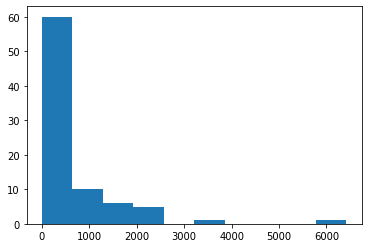

In [60]:
plt.hist(d['UPVotes'])